In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

import os

from source import utils
from source.analysis.setup.feature_type import FeatureType
from source.analysis.setup.subject import Subject
from source.constants import Constants
from source.preprocessing.activity_count.activity_count_feature_service import ActivityCountFeatureService
from source.preprocessing.activity_count.activity_count_service import ActivityCountService
from source.preprocessing.epoch import Epoch
from source.preprocessing.heart_rate.heart_rate_feature_service import HeartRateFeatureService
from source.preprocessing.heart_rate.heart_rate_service import HeartRateService
from source.preprocessing.interval import Interval
from source.preprocessing.time.time_based_feature_service import TimeBasedFeatureService
from source.mesa.mesa_actigraphy_service import MesaActigraphyService
from source.mesa.mesa_heart_rate_service import MesaHeartRateService
from source.mesa.mesa_psg_service import MesaPSGService
from source.mesa.mesa_time_based_service import MesaTimeBasedService
from source.mesa.metadata_service import MetadataService
from source.mesa.mesa_data_service import MesaDataService
import random

file_id='2757'
raw_labeled_sleep = MesaPSGService.load_raw(file_id)

import torch
import pyedflib as pyedflib
edf_file = pyedflib.EdfReader('/extern2/zgz/wq/sleep/sleep_classifiers' + '/data/mesa/polysomnography/edfs/mesa-sleep-' + file_id + '.edf')
signal_labels = edf_file.getSignalLabels()

edf_file.readSignal(signal_labels.index('Pleth')).shape[0]/edf_file.getSampleFrequencies()[signal_labels.index('Pleth')]
#heart_rate_collection = MesaHeartRateService.load_raw(file_id)
#activity_count_collection = MesaActigraphyService.load_raw(file_id)
#circadian_model = MesaTimeBasedService.load_circadian_model(file_id)

35999.0

In [1]:

from source import utils

ModuleNotFoundError: No module named 'source'

In [33]:
import torch
te = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test/test_ppg/x_6783.pt')

In [37]:
import os
import tqdm
import pickle
import numpy as np
import torch
i = '2757'

mode = 'train'
stage_reverse = {5:3, 4:2, 3:2, 2:1, 1:1, 0:0}

test_label = list()

y_raw = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/'+mode+'/raw/y_'+i+'.pt')
label = y_raw[:, 0].tolist()
label = [stage_reverse[j] for j in label]


count_list = list()
for j in range(len(label)-9):
    temp = list()
    temp.append(label[j:j+10].count(0))
    temp.append(label[j:j+10].count(1))
    temp.append(label[j:j+10].count(2))
    temp.append(label[j:j+10].count(3))
    count_list.append(temp)
count_list = np.array(count_list)

beg_list = list()
for j in range(len(label)-9):
    beg_item = list()
    for k in range(6):
        beg_frag = list()
        beg_frag.append((j + k) * 30 * 64)
        beg_frag.append((j + k + 5) * 30 * 64)
        beg_frag.append((j + k) * 30)
        beg_frag.append((j + k + 5) * 30)
        beg_frag.append(3 * (j + k))
        beg_frag.append(3 * (j + k + 5)-2)
        beg_frag.append(label[j + k + 2])
        beg_frag.append('0010')
        beg_item.append(beg_frag)
    
    beg_list.append(beg_item)
beg_list = np.array(beg_list)[count_list.max(1)<8].reshape(-1, 8)
beg_list = beg_list[np.unique(beg_list[:,0], return_index=True)[1]]
test_label.append(beg_list)
test_label = np.concatenate(test_label, axis = 0)

In [40]:
test_label.shape

(237, 8)

In [39]:
beg_list.shape

(237, 8)

In [42]:
import pickle
with open('mesa/test_frag150_label.pkl', 'rb') as f:
    temp = pickle.load(f)

In [45]:
temp

array([['1000320', '1009920', '15630', ..., '1576', '0', '0081'],
       ['1002240', '1011840', '15660', ..., '1579', '0', '0081'],
       ['1004160', '1013760', '15690', ..., '1582', '0', '0081'],
       ...,
       ['996480', '1006080', '15570', ..., '1570', '0', '6807'],
       ['99840', '109440', '1560', ..., '169', '1', '6807'],
       ['998400', '1008000', '15600', ..., '1573', '1', '6807']],
      dtype='<U21')

In [33]:
test_label.reshape(-1,8)[ np.unique(test_label.reshape(-1,8)[:,0], return_index=True)[1]]

array([['0', '9600', '0', ..., '13', '0', '0010'],
       ['1029120', '1038720', '16080', ..., '1621', '1', '0010'],
       ['1031040', '1040640', '16110', ..., '1624', '1', '0010'],
       ...,
       ['988800', '998400', '15450', ..., '1558', '1', '0010'],
       ['990720', '1000320', '15480', ..., '1561', '1', '0010'],
       ['992640', '1002240', '15510', ..., '1564', '1', '0010']],
      dtype='<U21')

In [9]:
torch.unique(torch.nan_to_num(te, 0)[:,,:])

tensor([0.], dtype=torch.float64)

In [20]:
torch.unique(torch.isnan(te[:, 3, :]))

tensor([True])

In [6]:
edf_file.readSignal(signal_labels.index('Pleth')).shape[0]

9215744

In [5]:
raw_labeled_sleep[1:][0]

[1, 11760.0, 60.0]

In [2]:
raw_labeled_sleep = MesaPSGService.load_raw(file_id)
signal_labels = edf_file.getSignalLabels()
ppg = edf_file.readSignal(signal_labels.index('Pleth'))

In [9]:
from utils import bandpass_filter
filtered_sig = bandpass_filter(
    sig=ppg, fs=int(edf_file.getSampleFrequencies()[signal_labels.index('Pleth')]), lowcut=0.5, highcut=3.7)

In [10]:
filtered_sig.shape

(9215744,)

In [ ]:
from ppg_sqa import sqa
clean_indices, noisy_indices = sqa(
    sig=filtered_sig, sampling_rate= int(edf_file.getSampleFrequencies()[signal_labels.index('Pleth')]), filter_signal=False)

In [ ]:
clean_indices

In [9]:
all_files = MetadataService.get_all_files()
all_subjects = []
for file in all_files:
    file_id = file[-8:-4]
    all_subjects.append(file_id)

In [2]:
import os

In [16]:
os.listdir('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs')[0]

'cfs-visit5-800071.edf'

In [15]:
os.listdir('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs')[0][-10:-4]

'800071'

In [18]:
import pyedflib as pyedflib
edf_file = pyedflib.EdfReader('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs/cfs-visit5-800071.edf')

In [23]:
'PlethWV' not in edf_file.getSignalLabels()

True

In [31]:
import numpy as np
np.unique(all_subjects)

array([''], dtype='<U1')

In [34]:
all_files

'cfs-visit5-800071.edf'

In [59]:
edf_file = pyedflib.EdfReader('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs/cfs-visit5-800002.edf')
signal_labels = edf_file.getSignalLabels()
x = edf_file.readSignal(signal_labels.index('PlethWV'))

read -1, less than 4826880 requested!!!


In [63]:
signal_labels.index('PlethWV')

23

In [62]:
edf_file.getSignalLabels()

['C3',
 'C4',
 'M1',
 'M2',
 'LOC',
 'ROC',
 'ECG2',
 'ECG1',
 'EMG1',
 'EMG2',
 'EMG3',
 'L Leg',
 'R Leg',
 'AIRFLOW',
 'THOR EFFORT',
 'ABDO EFFORT',
 'SNORE',
 'SUM',
 'POSITION',
 'OX STATUS',
 'PULSE',
 'SpO2',
 'NASAL PRES',
 'PlethWV',
 'Light',
 'HRate']

In [64]:
edf_file.readSignal(23)

read -1, less than 4826880 requested!!!


array([0., 0., 0., ..., 0., 0., 0.])

In [66]:
import pyedflib as pyedflib
from pyedflib import highlevel

from xml.dom import minidom
import torch
import tqdm 

stage_to_num = {'Stage 4 sleep|4': 4, 'Stage 3 sleep|3': 3, 'Stage 2 sleep|2': 2, 'Stage 1 sleep|1': 1,
                        'Wake|0': 0, 'REM sleep|5': 5}

all_files = os.listdir('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs')
all_subjects = []
for file in all_files:
    if(len(file) != 21 ):
        continue
    file_id = file[-10:-4]
    all_subjects.append(file_id)
#random.shuffle(all_subjects)
count = 0
#spl='test'

for file_id in tqdm.tqdm(all_subjects):
    signals, signal_headers, header = highlevel.read_edf('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs/cfs-visit5-' + str(file_id) + '.edf')
    
    signal_labels = [i['label'] for i in signal_headers]
    if 'PlethWV' not in signal_labels:
        continue
    x = signals[signal_labels.index('PlethWV')]
    torch.save(torch.tensor(np.array(x)),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/raw/x_'+str(file_id)+'.pt')
    count+=1
#    if(count>200):
#        spl='train'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 730/730 [1:34:41<00:00,  7.78s/it]


In [47]:
import pyedflib as pyedflib

from xml.dom import minidom
import torch
import tqdm 

stage_to_num = {'Stage 4 sleep|4': 4, 'Stage 3 sleep|3': 3, 'Stage 2 sleep|2': 2, 'Stage 1 sleep|1': 1,
                        'Wake|0': 0, 'REM sleep|5': 5}

all_files = os.listdir('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs')
all_subjects = []
for file in all_files:
    if(len(file) != 21 ):
        continue
    file_id = file[-10:-4]
    all_subjects.append(file_id)
#random.shuffle(all_subjects)
count = 0
#spl='test'

for file_id in tqdm.tqdm(all_subjects):
    edf_file = pyedflib.EdfReader('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs/cfs-visit5-' + str(file_id) + '.edf')
    if 'PlethWV' not in edf_file.getSignalLabels():
        continue
    signal_labels = edf_file.getSignalLabels()
    x = edf_file.readSignal(signal_labels.index('PlethWV'))
    y = list()
    xml_document = minidom.parse(
    '/extern2/zgz/wq/data/nsrr/cfs/polysomnography/annotations-events-nsrr' + '/cfs-visit5-' + str(file_id) + '-nsrr.xml')
    list_of_scored_events = xml_document.getElementsByTagName('ScoredEvent')

    stage_data = []
    
    for scored_event in list_of_scored_events:  # 3 is stage, 5 is start, 7 is duration
        duration = scored_event.childNodes[7].childNodes[0].nodeValue
        start = scored_event.childNodes[5].childNodes[0].nodeValue
        stage = scored_event.childNodes[3].childNodes[0].nodeValue
    
        if stage in stage_to_num:#筛选睡眠阶段
            # # For debugging: print(file_id + ' ' + str(stage) + ' ' + str(start) + ' ' + str(duration))
            stage_data.append([stage_to_num[stage], float(start), float(duration)])
    
    for staged_window in stage_data[:]:  # Ignore last PSG overflow entry: it's long & doesn't have valid HR
        elapsed_time_counter = 0
        stage_value = staged_window[0]
        duration = staged_window[2]
    
        while elapsed_time_counter < duration:
            y.append(stage_value)
            elapsed_time_counter = elapsed_time_counter + 30

    torch.save(torch.tensor(np.array(x)),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all/raw/x_'+str(file_id)+'.pt')
    torch.save(torch.tensor(np.array(y)),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all/label/y_'+str(file_id)+'.pt')
    count+=1
#    if(count>200):
#        spl='train'


  0%|                                                                                                                                                                                                                                                           | 0/730 [00:00<?, ?it/s]

read -1, less than 4976640 requested!!!


  1%|█▎                                                                                                                                                                                                                                                 | 4/730 [00:00<01:16,  9.46it/s]

read -1, less than 3717120 requested!!!


  1%|██▎                                                                                                                                                                                                                                                | 7/730 [00:00<01:40,  7.20it/s]

read -1, less than 4938240 requested!!!


  1%|██▋                                                                                                                                                                                                                                                | 8/730 [00:01<02:14,  5.37it/s]

read -1, less than 4093440 requested!!!


  2%|███▋                                                                                                                                                                                                                                              | 11/730 [00:01<01:45,  6.85it/s]

read -1, less than 4439040 requested!!!


  2%|███▉                                                                                                                                                                                                                                              | 12/730 [00:02<02:37,  4.57it/s]

read -1, less than 4012800 requested!!!


  2%|████▎                                                                                                                                                                                                                                             | 13/730 [00:02<02:53,  4.14it/s]

read -1, less than 4366080 requested!!!


  2%|████▋                                                                                                                                                                                                                                             | 14/730 [00:03<03:39,  3.27it/s]

read -1, less than 4704000 requested!!!


  2%|████▉                                                                                                                                                                                                                                             | 15/730 [00:03<03:50,  3.10it/s]

read -1, less than 4730880 requested!!!


  2%|█████▎                                                                                                                                                                                                                                            | 16/730 [00:03<03:52,  3.07it/s]

read -1, less than 4047360 requested!!!


  2%|█████▉                                                                                                                                                                                                                                            | 18/730 [00:04<03:32,  3.35it/s]

read -1, less than 4308480 requested!!!


  3%|██████▎                                                                                                                                                                                                                                           | 19/730 [00:04<03:38,  3.26it/s]

read -1, less than 4227840 requested!!!


  3%|██████▋                                                                                                                                                                                                                                           | 20/730 [00:04<03:48,  3.11it/s]

read -1, less than 4442880 requested!!!


  3%|████████▎                                                                                                                                                                                                                                         | 25/730 [00:05<02:04,  5.68it/s]

read -1, less than 3659520 requested!!!


  4%|████████▉                                                                                                                                                                                                                                         | 27/730 [00:05<02:15,  5.18it/s]

read -1, less than 4619520 requested!!!


  4%|█████████▌                                                                                                                                                                                                                                        | 29/730 [00:06<02:25,  4.81it/s]

read -1, less than 4592640 requested!!!


  4%|█████████▉                                                                                                                                                                                                                                        | 30/730 [00:06<03:10,  3.68it/s]

read -1, less than 4776960 requested!!!


  5%|███████████▎                                                                                                                                                                                                                                      | 34/730 [00:07<02:04,  5.60it/s]

read -1, less than 4596480 requested!!!


  5%|████████████▉                                                                                                                                                                                                                                     | 39/730 [00:07<01:41,  6.78it/s]

read -1, less than 4323840 requested!!!


  6%|█████████████▌                                                                                                                                                                                                                                    | 41/730 [00:08<01:42,  6.70it/s]

read -1, less than 4853760 requested!!!


  6%|█████████████▉                                                                                                                                                                                                                                    | 42/730 [00:08<02:02,  5.63it/s]

read -1, less than 3870720 requested!!!


  6%|██████████████▉                                                                                                                                                                                                                                   | 45/730 [00:08<01:46,  6.42it/s]

read -1, less than 4830720 requested!!!


  7%|███████████████▉                                                                                                                                                                                                                                  | 48/730 [00:09<01:34,  7.23it/s]

read -1, less than 4661760 requested!!!


  7%|████████████████▏                                                                                                                                                                                                                                 | 49/730 [00:09<01:59,  5.70it/s]

read -1, less than 4711680 requested!!!


  7%|████████████████▌                                                                                                                                                                                                                                 | 50/730 [00:09<02:17,  4.93it/s]

read -1, less than 5126400 requested!!!


  7%|█████████████████▉                                                                                                                                                                                                                                | 54/730 [00:10<02:00,  5.60it/s]

read -1, less than 4243200 requested!!!


  8%|██████████████████▏                                                                                                                                                                                                                               | 55/730 [00:10<02:18,  4.89it/s]

read -1, less than 4853760 requested!!!


  8%|██████████████████▉                                                                                                                                                                                                                               | 57/730 [00:11<02:04,  5.41it/s]

read -1, less than 4892160 requested!!!


  8%|███████████████████▏                                                                                                                                                                                                                              | 58/730 [00:11<02:31,  4.44it/s]

read -1, less than 4431360 requested!!!


  8%|███████████████████▌                                                                                                                                                                                                                              | 59/730 [00:12<03:19,  3.36it/s]

read -1, less than 4120320 requested!!!


  9%|█████████████████████▌                                                                                                                                                                                                                            | 65/730 [00:12<01:30,  7.33it/s]

read -1, less than 4485120 requested!!!


 10%|███████████████████████▏                                                                                                                                                                                                                          | 70/730 [00:12<01:15,  8.79it/s]

read -1, less than 4561920 requested!!!


 10%|███████████████████████▊                                                                                                                                                                                                                          | 72/730 [00:13<01:29,  7.35it/s]

read -1, less than 3778560 requested!!!


 10%|████████████████████████▏                                                                                                                                                                                                                         | 73/730 [00:13<01:42,  6.39it/s]

read -1, less than 5030400 requested!!!


 10%|████████████████████████▊                                                                                                                                                                                                                         | 75/730 [00:13<01:42,  6.37it/s]

read -1, less than 4569600 requested!!!


 10%|█████████████████████████▏                                                                                                                                                                                                                        | 76/730 [00:14<01:58,  5.51it/s]

read -1, less than 4062720 requested!!!


 11%|█████████████████████████▌                                                                                                                                                                                                                        | 77/730 [00:14<02:18,  4.72it/s]

read -1, less than 4746240 requested!!!


 11%|█████████████████████████▊                                                                                                                                                                                                                        | 78/730 [00:15<03:00,  3.60it/s]

read -1, less than 3909120 requested!!!


 11%|██████████████████████████▌                                                                                                                                                                                                                       | 80/730 [00:15<02:46,  3.90it/s]

read -1, less than 4423680 requested!!!


 11%|███████████████████████████▏                                                                                                                                                                                                                      | 82/730 [00:15<02:20,  4.62it/s]

read -1, less than 5053440 requested!!!


 11%|███████████████████████████▌                                                                                                                                                                                                                      | 83/730 [00:16<02:40,  4.02it/s]

read -1, less than 4696320 requested!!!


 12%|███████████████████████████▊                                                                                                                                                                                                                      | 84/730 [00:16<02:50,  3.78it/s]

read -1, less than 4450560 requested!!!


 12%|████████████████████████████▏                                                                                                                                                                                                                     | 85/730 [00:16<02:50,  3.78it/s]

read -1, less than 4846080 requested!!!


 12%|████████████████████████████▌                                                                                                                                                                                                                     | 86/730 [00:17<03:40,  2.92it/s]

read -1, less than 4665600 requested!!!


 12%|█████████████████████████████▏                                                                                                                                                                                                                    | 88/730 [00:17<02:52,  3.73it/s]

read -1, less than 4442880 requested!!!


 12%|█████████████████████████████▊                                                                                                                                                                                                                    | 90/730 [00:18<02:49,  3.78it/s]

read -1, less than 4857600 requested!!!


 13%|██████████████████████████████▍                                                                                                                                                                                                                   | 92/730 [00:18<02:40,  3.98it/s]

read -1, less than 4462080 requested!!!


 13%|███████████████████████████████▏                                                                                                                                                                                                                  | 94/730 [00:19<02:38,  4.00it/s]

read -1, less than 4446720 requested!!!


 14%|█████████████████████████████████                                                                                                                                                                                                                | 100/730 [00:19<01:27,  7.23it/s]

read -1, less than 3843840 requested!!!


 14%|█████████████████████████████████▋                                                                                                                                                                                                               | 102/730 [00:19<01:28,  7.09it/s]

read -1, less than 4055040 requested!!!


 14%|██████████████████████████████████▋                                                                                                                                                                                                              | 105/730 [00:20<01:20,  7.75it/s]

read -1, less than 4861440 requested!!!


 15%|███████████████████████████████████▎                                                                                                                                                                                                             | 107/730 [00:20<01:36,  6.44it/s]

read -1, less than 4565760 requested!!!


 15%|███████████████████████████████████▉                                                                                                                                                                                                             | 109/730 [00:21<01:44,  5.96it/s]

read -1, less than 4435200 requested!!!


 15%|████████████████████████████████████▋                                                                                                                                                                                                            | 111/730 [00:21<01:42,  6.03it/s]

read -1, less than 4592640 requested!!!


 15%|█████████████████████████████████████▎                                                                                                                                                                                                           | 113/730 [00:21<01:45,  5.86it/s]

read -1, less than 4865280 requested!!!


 16%|█████████████████████████████████████▉                                                                                                                                                                                                           | 115/730 [00:22<01:39,  6.17it/s]

read -1, less than 5076480 requested!!!


 16%|██████████████████████████████████████▉                                                                                                                                                                                                          | 118/730 [00:22<01:22,  7.44it/s]

read -1, less than 4542720 requested!!!


 16%|███████████████████████████████████████▎                                                                                                                                                                                                         | 119/730 [00:22<01:47,  5.71it/s]

read -1, less than 4020480 requested!!!


 17%|████████████████████████████████████████▎                                                                                                                                                                                                        | 122/730 [00:23<01:38,  6.20it/s]

read -1, less than 4316160 requested!!!


 17%|████████████████████████████████████████▌                                                                                                                                                                                                        | 123/730 [00:23<02:01,  4.98it/s]

read -1, less than 3886080 requested!!!


 17%|████████████████████████████████████████▉                                                                                                                                                                                                        | 124/730 [00:23<02:21,  4.27it/s]

read -1, less than 4512000 requested!!!


 17%|█████████████████████████████████████████▎                                                                                                                                                                                                       | 125/730 [00:24<02:22,  4.25it/s]

read -1, less than 5084160 requested!!!


 17%|█████████████████████████████████████████▉                                                                                                                                                                                                       | 127/730 [00:24<02:23,  4.21it/s]

read -1, less than 4404480 requested!!!


 18%|██████████████████████████████████████████▎                                                                                                                                                                                                      | 128/730 [00:24<02:30,  4.00it/s]

read -1, less than 4512000 requested!!!


 18%|██████████████████████████████████████████▌                                                                                                                                                                                                      | 129/730 [00:25<02:33,  3.91it/s]

read -1, less than 4608000 requested!!!


 18%|███████████████████████████████████████████▌                                                                                                                                                                                                     | 132/730 [00:25<02:01,  4.91it/s]

read -1, less than 3985920 requested!!!


 18%|████████████████████████████████████████████▌                                                                                                                                                                                                    | 135/730 [00:26<01:46,  5.59it/s]

read -1, less than 4327680 requested!!!


 19%|█████████████████████████████████████████████▌                                                                                                                                                                                                   | 138/730 [00:26<01:28,  6.71it/s]

read -1, less than 4515840 requested!!!


 19%|██████████████████████████████████████████████▏                                                                                                                                                                                                  | 140/730 [00:26<01:41,  5.83it/s]

read -1, less than 4588800 requested!!!


 20%|███████████████████████████████████████████████▌                                                                                                                                                                                                 | 144/730 [00:27<01:16,  7.68it/s]

read -1, less than 4558080 requested!!!


 20%|███████████████████████████████████████████████▊                                                                                                                                                                                                 | 145/730 [00:27<01:29,  6.53it/s]

read -1, less than 5034240 requested!!!


 20%|████████████████████████████████████████████████▌                                                                                                                                                                                                | 147/730 [00:27<01:38,  5.94it/s]

read -1, less than 4066560 requested!!!


 20%|████████████████████████████████████████████████▊                                                                                                                                                                                                | 148/730 [00:28<01:47,  5.40it/s]

read -1, less than 4646400 requested!!!


 21%|█████████████████████████████████████████████████▊                                                                                                                                                                                               | 151/730 [00:28<01:21,  7.07it/s]

read -1, less than 4535040 requested!!!


 21%|██████████████████████████████████████████████████▌                                                                                                                                                                                              | 153/730 [00:28<01:34,  6.13it/s]

read -1, less than 4869120 requested!!!


 21%|███████████████████████████████████████████████████▌                                                                                                                                                                                             | 156/730 [00:29<01:19,  7.18it/s]

read -1, less than 4035840 requested!!!


 22%|███████████████████████████████████████████████████▊                                                                                                                                                                                             | 157/730 [00:29<01:36,  5.94it/s]

read -1, less than 4166400 requested!!!


 22%|█████████████████████████████████████████████████████▏                                                                                                                                                                                           | 161/730 [00:29<01:17,  7.35it/s]

read -1, less than 4926720 requested!!!


 22%|█████████████████████████████████████████████████████▍                                                                                                                                                                                           | 162/730 [00:30<01:30,  6.31it/s]

read -1, less than 4654080 requested!!!


 22%|██████████████████████████████████████████████████████▏                                                                                                                                                                                          | 164/730 [00:30<01:54,  4.95it/s]

read -1, less than 3916800 requested!!!


 23%|███████████████████████████████████████████████████████▏                                                                                                                                                                                         | 167/730 [00:31<01:32,  6.10it/s]

read -1, less than 4435200 requested!!!


 23%|████████████████████████████████████████████████████████▍                                                                                                                                                                                        | 171/730 [00:31<01:14,  7.50it/s]

read -1, less than 3820800 requested!!!


 24%|████████████████████████████████████████████████████████▊                                                                                                                                                                                        | 172/730 [00:31<01:25,  6.55it/s]

read -1, less than 3294720 requested!!!


 24%|██████████████████████████████████████████████████████████                                                                                                                                                                                       | 176/730 [00:32<01:07,  8.22it/s]

read -1, less than 4139520 requested!!!


 24%|██████████████████████████████████████████████████████████▍                                                                                                                                                                                      | 177/730 [00:32<01:18,  7.08it/s]

read -1, less than 3859200 requested!!!


 25%|████████████████████████████████████████████████████████████▍                                                                                                                                                                                    | 183/730 [00:32<00:51, 10.70it/s]

read -1, less than 4727040 requested!!!
read -1, less than 4750080 requested!!!


 25%|█████████████████████████████████████████████████████████████                                                                                                                                                                                    | 185/730 [00:33<01:19,  6.89it/s]

read -1, less than 4439040 requested!!!


 25%|█████████████████████████████████████████████████████████████▍                                                                                                                                                                                   | 186/730 [00:33<01:39,  5.49it/s]

read -1, less than 4446720 requested!!!


 26%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                   | 187/730 [00:34<01:46,  5.08it/s]

read -1, less than 3782400 requested!!!


 26%|██████████████████████████████████████████████████████████████                                                                                                                                                                                   | 188/730 [00:34<02:05,  4.33it/s]

read -1, less than 4512000 requested!!!


 26%|██████████████████████████████████████████████████████████████▋                                                                                                                                                                                  | 190/730 [00:34<01:48,  4.96it/s]

read -1, less than 4519680 requested!!!


 26%|███████████████████████████████████████████████████████████████▍                                                                                                                                                                                 | 192/730 [00:35<01:48,  4.97it/s]

read -1, less than 4458240 requested!!!


 27%|████████████████████████████████████████████████████████████████▍                                                                                                                                                                                | 195/730 [00:35<01:20,  6.64it/s]

read -1, less than 4373760 requested!!!


 27%|█████████████████████████████████████████████████████████████████                                                                                                                                                                                | 197/730 [00:35<01:32,  5.75it/s]

read -1, less than 4350720 requested!!!


 27%|█████████████████████████████████████████████████████████████████▎                                                                                                                                                                               | 198/730 [00:36<01:55,  4.61it/s]

read -1, less than 3686400 requested!!!


 27%|█████████████████████████████████████████████████████████████████▋                                                                                                                                                                               | 199/730 [00:36<01:59,  4.45it/s]

read -1, less than 4331520 requested!!!


 28%|███████████████████████████████████████████████████████████████████▎                                                                                                                                                                             | 204/730 [00:36<01:09,  7.52it/s]

read -1, less than 4857600 requested!!!


 28%|███████████████████████████████████████████████████████████████████▋                                                                                                                                                                             | 205/730 [00:37<01:28,  5.95it/s]

read -1, less than 4166400 requested!!!


 29%|████████████████████████████████████████████████████████████████████▉                                                                                                                                                                            | 209/730 [00:37<01:20,  6.51it/s]

read -1, less than 4185600 requested!!!


 29%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 211/730 [00:38<01:22,  6.28it/s]

read -1, less than 4692480 requested!!!


 30%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 216/730 [00:38<00:59,  8.62it/s]

read -1, less than 4508160 requested!!!


 30%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                                                         | 217/730 [00:38<01:23,  6.12it/s]

read -1, less than 4389120 requested!!!


 30%|███████████████████████████████████████████████████████████████████████▉                                                                                                                                                                         | 218/730 [00:39<01:42,  4.99it/s]

read -1, less than 4561920 requested!!!


 30%|████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                        | 219/730 [00:39<01:52,  4.52it/s]

read -1, less than 4512000 requested!!!


 30%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                       | 222/730 [00:39<01:23,  6.06it/s]

read -1, less than 3033600 requested!!!


 31%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 223/730 [00:40<01:30,  5.58it/s]

read -1, less than 4673280 requested!!!


 31%|█████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                       | 224/730 [00:40<02:26,  3.46it/s]

read -1, less than 3974400 requested!!!


 31%|██████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                      | 225/730 [00:41<02:28,  3.40it/s]

read -1, less than 3797760 requested!!!


 31%|██████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                      | 226/730 [00:41<02:27,  3.41it/s]

read -1, less than 4769280 requested!!!


 31%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                      | 227/730 [00:41<02:32,  3.29it/s]

read -1, less than 4354560 requested!!!


 31%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                     | 228/730 [00:42<02:31,  3.32it/s]

read -1, less than 4062720 requested!!!


 32%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 230/730 [00:42<01:59,  4.17it/s]

read -1, less than 4619520 requested!!!


 32%|████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                    | 233/730 [00:43<01:58,  4.21it/s]

read -1, less than 4266240 requested!!!


 32%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                   | 234/730 [00:43<02:20,  3.53it/s]

read -1, less than 4224000 requested!!!


 32%|█████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 235/730 [00:44<02:24,  3.42it/s]

read -1, less than 4362240 requested!!!


 33%|██████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                  | 238/730 [00:44<01:39,  4.94it/s]

read -1, less than 4289280 requested!!!


 33%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                  | 239/730 [00:44<02:02,  3.99it/s]

read -1, less than 4715520 requested!!!


 33%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                 | 241/730 [00:45<01:47,  4.54it/s]

read -1, less than 4611840 requested!!!


 33%|███████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                 | 242/730 [00:45<02:10,  3.75it/s]

read -1, less than 4469760 requested!!!


 34%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                | 245/730 [00:46<01:48,  4.46it/s]

read -1, less than 4800000 requested!!!


 34%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                               | 246/730 [00:46<02:06,  3.81it/s]

read -1, less than 4780800 requested!!!


 34%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                              | 250/730 [00:46<01:24,  5.66it/s]

read -1, less than 4584960 requested!!!


 35%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                             | 254/730 [00:47<01:07,  7.07it/s]

read -1, less than 4062720 requested!!!


 35%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                            | 255/730 [00:47<01:24,  5.63it/s]

read -1, less than 4135680 requested!!!


 35%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                           | 258/730 [00:47<01:08,  6.92it/s]

read -1, less than 4769280 requested!!!


 35%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                           | 259/730 [00:48<01:19,  5.94it/s]

read -1, less than 5214720 requested!!!


 36%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                         | 264/730 [00:48<00:56,  8.31it/s]

read -1, less than 4734720 requested!!!


 37%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 268/730 [00:48<00:50,  9.18it/s]

read -1, less than 4688640 requested!!!


 38%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                      | 274/730 [00:49<00:39, 11.42it/s]

read -1, less than 4780800 requested!!!


 38%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                     | 277/730 [00:49<00:41, 11.02it/s]

read -1, less than 4227840 requested!!!


 39%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                   | 283/730 [00:50<00:37, 12.03it/s]

read -1, less than 4139520 requested!!!


 39%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                   | 285/730 [00:50<00:40, 11.02it/s]

read -1, less than 4312320 requested!!!
read -1, less than 4581120 requested!!!


 39%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 287/730 [00:50<00:55,  8.02it/s]

read -1, less than 4066560 requested!!!


 39%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                  | 288/730 [00:51<01:03,  6.95it/s]

read -1, less than 4565760 requested!!!


 40%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 289/730 [00:51<01:24,  5.25it/s]

read -1, less than 4055040 requested!!!


 40%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                | 292/730 [00:52<01:12,  6.03it/s]

read -1, less than 4377600 requested!!!
read -1, less than 4454400 requested!!!


 40%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                | 294/730 [00:52<01:01,  7.09it/s]

read -1, less than 4381440 requested!!!


 41%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 298/730 [00:52<00:53,  8.10it/s]

read -1, less than 4949760 requested!!!
read -1, less than 4750080 requested!!!


 41%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 302/730 [00:53<00:40, 10.61it/s]

read -1, less than 4465920 requested!!!
read -1, less than 4654080 requested!!!


 42%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                            | 304/730 [00:53<00:37, 11.48it/s]

read -1, less than 4608000 requested!!!


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            | 306/730 [00:53<00:54,  7.79it/s]

read -1, less than 5034240 requested!!!
read -1, less than 4281600 requested!!!


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 312/730 [00:53<00:38, 10.78it/s]

read -1, less than 5134080 requested!!!


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                         | 314/730 [00:54<00:41, 10.07it/s]

read -1, less than 5126400 requested!!!
read -1, less than 4293120 requested!!!


 43%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 316/730 [00:54<00:50,  8.25it/s]

read -1, less than 4753920 requested!!!
read -1, less than 4776960 requested!!!


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 322/730 [00:54<00:37, 10.90it/s]

read -1, less than 5226240 requested!!!


 45%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 332/730 [00:55<00:20, 19.56it/s]

read -1, less than 4177920 requested!!!
read -1, less than 4704000 requested!!!
read -1, less than 4723200 requested!!!


 46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                  | 335/730 [00:55<00:29, 13.29it/s]

read -1, less than 5107200 requested!!!


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                 | 338/730 [00:56<00:36, 10.69it/s]

read -1, less than 4857600 requested!!!


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                | 340/730 [00:56<00:36, 10.56it/s]

read -1, less than 4058880 requested!!!
read -1, less than 4826880 requested!!!
read -1, less than 4961280 requested!!!


 47%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 345/730 [00:56<00:38,  9.95it/s]

read -1, less than 4439040 requested!!!
read -1, less than 4512000 requested!!!


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 347/730 [00:57<00:42,  8.93it/s]

read -1, less than 4531200 requested!!!


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                             | 351/730 [00:57<00:40,  9.45it/s]

read -1, less than 4488960 requested!!!
read -1, less than 4523520 requested!!!


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 359/730 [00:57<00:22, 16.39it/s]

read -1, less than 4995840 requested!!!
read -1, less than 4373760 requested!!!


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 363/730 [00:58<00:29, 12.56it/s]

read -1, less than 4707840 requested!!!
read -1, less than 4680960 requested!!!


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 370/730 [00:58<00:23, 15.04it/s]

read -1, less than 4220160 requested!!!
read -1, less than 4224000 requested!!!


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 372/730 [00:59<00:34, 10.44it/s]

read -1, less than 4623360 requested!!!
read -1, less than 4727040 requested!!!


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 376/730 [00:59<00:34, 10.33it/s]

read -1, less than 4968960 requested!!!
read -1, less than 4730880 requested!!!


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                    | 378/730 [01:00<00:45,  7.70it/s]

read -1, less than 5130240 requested!!!


 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 383/730 [01:00<00:29, 11.79it/s]

read -1, less than 3648000 requested!!!
read -1, less than 4500480 requested!!!


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                 | 387/730 [01:00<00:29, 11.68it/s]

read -1, less than 4573440 requested!!!
read -1, less than 4650240 requested!!!


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 389/730 [01:00<00:32, 10.50it/s]

read -1, less than 4807680 requested!!!


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 394/730 [01:01<00:34,  9.81it/s]

read -1, less than 4581120 requested!!!
read -1, less than 4657920 requested!!!


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                             | 398/730 [01:01<00:29, 11.32it/s]

read -1, less than 4204800 requested!!!
read -1, less than 4657920 requested!!!


 55%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 403/730 [01:01<00:22, 14.28it/s]

read -1, less than 4535040 requested!!!
read -1, less than 4239360 requested!!!


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                          | 407/730 [01:02<00:32,  9.86it/s]

read -1, less than 4404480 requested!!!
read -1, less than 4615680 requested!!!


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                         | 411/730 [01:02<00:34,  9.33it/s]

read -1, less than 4538880 requested!!!
read -1, less than 4688640 requested!!!


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 413/730 [01:03<00:37,  8.44it/s]

read -1, less than 4707840 requested!!!
read -1, less than 5114880 requested!!!


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                       | 418/730 [01:03<00:27, 11.47it/s]

read -1, less than 3955200 requested!!!
read -1, less than 4892160 requested!!!


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                     | 422/730 [01:03<00:22, 13.83it/s]

read -1, less than 4826880 requested!!!


 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                    | 427/730 [01:04<00:23, 12.90it/s]

read -1, less than 4569600 requested!!!
read -1, less than 5072640 requested!!!


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                   | 429/730 [01:04<00:27, 10.84it/s]

read -1, less than 4139520 requested!!!
read -1, less than 4700160 requested!!!


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                 | 435/730 [01:04<00:20, 14.25it/s]

read -1, less than 4538880 requested!!!
read -1, less than 4711680 requested!!!


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 437/730 [01:05<00:25, 11.61it/s]

read -1, less than 4757760 requested!!!
read -1, less than 4508160 requested!!!


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 441/730 [01:05<00:28, 10.28it/s]

read -1, less than 5064960 requested!!!


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 447/730 [01:05<00:17, 16.13it/s]

read -1, less than 5088000 requested!!!
read -1, less than 3955200 requested!!!


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                            | 451/730 [01:06<00:20, 13.64it/s]

read -1, less than 3840000 requested!!!


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 453/730 [01:06<00:20, 13.61it/s]

read -1, less than 4638720 requested!!!
read -1, less than 3840000 requested!!!


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 455/730 [01:06<00:26, 10.30it/s]

read -1, less than 4788480 requested!!!
read -1, less than 5064960 requested!!!


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 457/730 [01:06<00:24, 11.31it/s]

read -1, less than 4642560 requested!!!
read -1, less than 3909120 requested!!!


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 459/730 [01:06<00:27,  9.88it/s]

read -1, less than 5076480 requested!!!


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 462/730 [01:07<00:29,  8.98it/s]

read -1, less than 5038080 requested!!!
read -1, less than 4834560 requested!!!


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 465/730 [01:07<00:32,  8.11it/s]

read -1, less than 3759360 requested!!!
read -1, less than 4450560 requested!!!


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 467/730 [01:08<00:31,  8.34it/s]

read -1, less than 4861440 requested!!!


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 475/730 [01:08<00:23, 10.95it/s]

read -1, less than 4331520 requested!!!
read -1, less than 4588800 requested!!!


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 480/730 [01:08<00:19, 12.82it/s]

read -1, less than 4588800 requested!!!
read -1, less than 4512000 requested!!!


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 482/730 [01:09<00:19, 13.02it/s]

read -1, less than 4869120 requested!!!
read -1, less than 4515840 requested!!!


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 487/730 [01:09<00:22, 10.98it/s]

read -1, less than 5026560 requested!!!


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 491/730 [01:09<00:16, 14.25it/s]

read -1, less than 4811520 requested!!!
read -1, less than 4408320 requested!!!


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 496/730 [01:10<00:16, 13.79it/s]

read -1, less than 4784640 requested!!!
read -1, less than 4654080 requested!!!


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 499/730 [01:10<00:15, 15.04it/s]

read -1, less than 4339200 requested!!!


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 503/730 [01:10<00:17, 12.92it/s]

read -1, less than 4224000 requested!!!
read -1, less than 4876800 requested!!!


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                          | 505/730 [01:11<00:23,  9.39it/s]

read -1, less than 4753920 requested!!!
read -1, less than 4531200 requested!!!


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 509/730 [01:11<00:22, 10.04it/s]

read -1, less than 4573440 requested!!!
read -1, less than 4504320 requested!!!


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 511/730 [01:11<00:24,  9.00it/s]

read -1, less than 4289280 requested!!!
read -1, less than 4212480 requested!!!


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 513/730 [01:11<00:22,  9.67it/s]

read -1, less than 4934400 requested!!!


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 517/730 [01:12<00:23,  9.13it/s]

read -1, less than 4465920 requested!!!
read -1, less than 4930560 requested!!!


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 519/730 [01:12<00:24,  8.63it/s]

read -1, less than 4592640 requested!!!
read -1, less than 4308480 requested!!!


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 524/730 [01:12<00:16, 12.53it/s]

read -1, less than 3436800 requested!!!
read -1, less than 4273920 requested!!!
read -1, less than 4266240 requested!!!


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 531/730 [01:13<00:15, 13.09it/s]

read -1, less than 4070400 requested!!!
read -1, less than 4323840 requested!!!


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 533/730 [01:13<00:14, 13.21it/s]

read -1, less than 5103360 requested!!!
read -1, less than 4158720 requested!!!


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 535/730 [01:13<00:16, 11.62it/s]

read -1, less than 5091840 requested!!!
read -1, less than 4773120 requested!!!


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 539/730 [01:14<00:20,  9.52it/s]

read -1, less than 4404480 requested!!!
read -1, less than 3905280 requested!!!


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 541/730 [01:14<00:22,  8.55it/s]

read -1, less than 4346880 requested!!!


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 543/730 [01:14<00:19,  9.48it/s]

read -1, less than 4343040 requested!!!
read -1, less than 4592640 requested!!!


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 554/730 [01:15<00:11, 14.74it/s]

read -1, less than 4669440 requested!!!
read -1, less than 4588800 requested!!!


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 558/730 [01:15<00:13, 12.98it/s]

read -1, less than 4999680 requested!!!


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 560/730 [01:16<00:12, 13.24it/s]

read -1, less than 4377600 requested!!!


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 567/730 [01:16<00:12, 13.31it/s]

read -1, less than 5084160 requested!!!
read -1, less than 4200960 requested!!!


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 573/730 [01:16<00:11, 13.28it/s]

read -1, less than 5015040 requested!!!
read -1, less than 4254720 requested!!!


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 579/730 [01:17<00:10, 14.13it/s]

read -1, less than 4704000 requested!!!
read -1, less than 4711680 requested!!!


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 584/730 [01:17<00:10, 13.80it/s]

read -1, less than 4592640 requested!!!


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 586/730 [01:18<00:16,  8.94it/s]

read -1, less than 4508160 requested!!!
read -1, less than 4554240 requested!!!


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 591/730 [01:18<00:14,  9.74it/s]

read -1, less than 5153280 requested!!!
read -1, less than 4780800 requested!!!


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 593/730 [01:19<00:17,  7.84it/s]

read -1, less than 3982080 requested!!!
read -1, less than 4669440 requested!!!


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 602/730 [01:19<00:09, 12.83it/s]

read -1, less than 4135680 requested!!!
read -1, less than 4650240 requested!!!


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 611/730 [01:20<00:07, 16.11it/s]

read -1, less than 4128000 requested!!!
read -1, less than 4235520 requested!!!


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 613/730 [01:20<00:08, 13.55it/s]

read -1, less than 4416000 requested!!!
read -1, less than 4492800 requested!!!


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 618/730 [01:20<00:08, 13.45it/s]

read -1, less than 4224000 requested!!!


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 623/730 [01:20<00:05, 18.96it/s]

read -1, less than 3682560 requested!!!


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 629/730 [01:21<00:06, 15.11it/s]

read -1, less than 4700160 requested!!!


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 631/730 [01:21<00:06, 14.55it/s]

read -1, less than 4550400 requested!!!


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 637/730 [01:22<00:11,  8.24it/s]

read -1, less than 4861440 requested!!!


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 639/730 [01:23<00:17,  5.25it/s]

read -1, less than 3978240 requested!!!


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 642/730 [01:23<00:17,  5.02it/s]

read -1, less than 4742400 requested!!!


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 643/730 [01:24<00:21,  4.04it/s]

read -1, less than 4377600 requested!!!


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 647/730 [01:25<00:20,  3.96it/s]

read -1, less than 4496640 requested!!!


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 654/730 [01:27<00:17,  4.44it/s]

read -1, less than 4992000 requested!!!


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 656/730 [01:27<00:21,  3.49it/s]

read -1, less than 4208640 requested!!!


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 657/730 [01:28<00:28,  2.54it/s]

read -1, less than 4154880 requested!!!


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 662/730 [01:29<00:21,  3.18it/s]

read -1, less than 4657920 requested!!!


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 665/730 [01:30<00:17,  3.73it/s]

read -1, less than 4396800 requested!!!


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 667/730 [01:31<00:22,  2.80it/s]

read -1, less than 2357760 requested!!!


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 668/730 [01:31<00:20,  3.00it/s]

read -1, less than 4177920 requested!!!


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 670/730 [01:32<00:23,  2.52it/s]

read -1, less than 4404480 requested!!!


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 674/730 [01:33<00:12,  4.58it/s]

read -1, less than 4688640 requested!!!


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 675/730 [01:33<00:14,  3.84it/s]

read -1, less than 4769280 requested!!!


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 679/730 [01:34<00:12,  4.04it/s]

read -1, less than 4473600 requested!!!


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 680/730 [01:34<00:12,  4.16it/s]

read -1, less than 4803840 requested!!!


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 683/730 [01:35<00:12,  3.83it/s]

read -1, less than 4385280 requested!!!


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 685/730 [01:35<00:07,  5.74it/s]

read -1, less than 4976640 requested!!!


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 687/730 [01:36<00:11,  3.82it/s]

read -1, less than 4573440 requested!!!


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 697/730 [01:38<00:05,  6.14it/s]

read -1, less than 4830720 requested!!!


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 699/730 [01:39<00:07,  4.37it/s]

read -1, less than 4765440 requested!!!


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 702/730 [01:39<00:04,  6.15it/s]

read -1, less than 4504320 requested!!!


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 703/730 [01:40<00:07,  3.66it/s]

read -1, less than 4573440 requested!!!


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 705/730 [01:41<00:09,  2.75it/s]

read -1, less than 4431360 requested!!!
read -1, less than 4293120 requested!!!


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 708/730 [01:42<00:06,  3.29it/s]

read -1, less than 3763200 requested!!!


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 710/730 [01:42<00:05,  3.47it/s]

read -1, less than 4358400 requested!!!


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 716/730 [01:43<00:01,  7.05it/s]

read -1, less than 4135680 requested!!!


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 719/730 [01:44<00:01,  6.05it/s]

read -1, less than 4657920 requested!!!


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 721/730 [01:44<00:02,  4.08it/s]

read -1, less than 4496640 requested!!!


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 723/730 [01:45<00:02,  3.41it/s]

read -1, less than 4277760 requested!!!


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 724/730 [01:46<00:02,  2.93it/s]

read -1, less than 3924480 requested!!!


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 726/730 [01:46<00:01,  2.91it/s]

read -1, less than 4535040 requested!!!


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 728/730 [01:47<00:00,  3.02it/s]

read -1, less than 4523520 requested!!!
read -1, less than 4143360 requested!!!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 730/730 [01:48<00:00,  6.73it/s]

read -1, less than 4581120 requested!!!


In [ ]:
import pyedflib as pyedflib

from xml.dom import minidom
import torch
import tqdm 

stage_to_num = {'Stage 4 sleep|4': 4, 'Stage 3 sleep|3': 3, 'Stage 2 sleep|2': 2, 'Stage 1 sleep|1': 1,
                        'Wake|0': 0, 'REM sleep|5': 5}

all_files = os.listdir('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs')
all_subjects = []
for file in all_files:
    if(len(file) != 21 ):
        continue
    file_id = file[-10:-4]
    all_subjects.append(file_id)
#random.shuffle(all_subjects)
count = 0
#spl='test'

for file_id in tqdm.tqdm(all_subjects):
    edf_file = pyedflib.EdfReader('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs/cfs-visit5-' + str(file_id) + '.edf')
    if 'PlethWV' not in edf_file.getSignalLabels():
        continue
    signal_labels = edf_file.getSignalLabels()
    x = edf_file.readSignal(signal_labels.index('PlethWV'))
    y = list()
    xml_document = minidom.parse(
    '/extern2/zgz/wq/data/nsrr/cfs/polysomnography/annotations-events-nsrr' + '/cfs-visit5-' + str(file_id) + '-nsrr.xml')
    list_of_scored_events = xml_document.getElementsByTagName('ScoredEvent')

    stage_data = []
    
    for scored_event in list_of_scored_events:  # 3 is stage, 5 is start, 7 is duration
        duration = scored_event.childNodes[7].childNodes[0].nodeValue
        start = scored_event.childNodes[5].childNodes[0].nodeValue
        stage = scored_event.childNodes[3].childNodes[0].nodeValue
    
        if stage in stage_to_num:#筛选睡眠阶段
            # # For debugging: print(file_id + ' ' + str(stage) + ' ' + str(start) + ' ' + str(duration))
            stage_data.append([stage_to_num[stage], float(start), float(duration)])
    
    for staged_window in stage_data[:]:  # Ignore last PSG overflow entry: it's long & doesn't have valid HR
        elapsed_time_counter = 0
        stage_value = staged_window[0]
        duration = staged_window[2]
    
        while elapsed_time_counter < duration:
            y.append(stage_value)
            elapsed_time_counter = elapsed_time_counter + 30

    torch.save(torch.tensor(np.array(x)),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all/raw/x_'+str(file_id)+'.pt')
    torch.save(torch.tensor(np.array(y)),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all/label/y_'+str(file_id)+'.pt')

In [3]:
import pyedflib as pyedflib

from xml.dom import minidom
import torch
import tqdm 


stage_to_num = {'Stage 4 sleep|4': 4, 'Stage 3 sleep|3': 3, 'Stage 2 sleep|2': 2, 'Stage 1 sleep|1': 1,
                        'Wake|0': 0, 'REM sleep|5': 5}

y = list()
xml_document = minidom.parse(
'/extern2/zgz/wq/data/nsrr/mesa/polysomnography/annotations-events-nsrr/mesa-sleep-' + str('0001') + '-nsrr.xml')
list_of_scored_events = xml_document.getElementsByTagName('ScoredEvent')

stage_data = []

for scored_event in list_of_scored_events:  # 3 is stage, 5 is start, 7 is duration
    duration = scored_event.childNodes[7].childNodes[0].nodeValue
    start = scored_event.childNodes[5].childNodes[0].nodeValue
    stage = scored_event.childNodes[3].childNodes[0].nodeValue

    if stage in stage_to_num:#筛选睡眠阶段
        # # For debugging: print(file_id + ' ' + str(stage) + ' ' + str(start) + ' ' + str(duration))
        stage_data.append([stage_to_num[stage], float(start), float(duration)])

for staged_window in stage_data[:]:  # Ignore last PSG overflow entry: it's long & doesn't have valid HR
    elapsed_time_counter = 0
    stage_value = staged_window[0]
    duration = staged_window[2]

    while elapsed_time_counter < duration:
        y.append(stage_value)
        elapsed_time_counter = elapsed_time_counter + 30


In [6]:
len(y)

1439

In [8]:
label = torch.load("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/mesa/label/y_" + '0001' + ".pt")

In [14]:
label[:, 0].tolist()==y

True

In [26]:
ahi_path + 'cfs-visit5-'+i+'-profusion.xml'

'/extern2/zgz/wq/data/nsrr/cfs/polysomnography/annotations-events-profusion/cfs-visit5-801393-profusion.xml'

In [27]:
os.path.exists(ahi_path + 'cfs-visit5-'+i+'-profusion.xml')

False

In [31]:
import os
import re
import tqdm
import pickle
import numpy as np
import torch
from label_ahi import getLabels

mode = 'train'

ahi_path = '/extern2/zgz/wq/data/nsrr/cfs/polysomnography/annotations-events-profusion/'

label_index = os.listdir('cfs/all/label')
resu = np.unique([re.findall(r'\d+', i)[0] for i in label_index])

In [34]:
import os
import re
import tqdm
import pickle
import numpy as np
import torch
from label_ahi import getLabels

mode = 'train'

ahi_path = '/extern2/zgz/wq/data/nsrr/cfs/polysomnography/annotations-events-profusion/'

label_index = os.listdir('cfs/all/label')
resu = np.unique([re.findall(r'\d+', i)[0] for i in label_index])

test_label = list()

for i in tqdm.tqdm(resu):
    if(not os.path.exists(ahi_path + 'cfs-visit5-'+i+'-profusion.xml')):
        continue
    test_label = list()
    ahi_label = getLabels(ahi_path + 'cfs-visit5-'+i+'-profusion.xml')
    for j in range(0, len(ahi_label['ahi_labels']), 30):
        if(np.any(ahi_label['ahi_labels'][j:j+30])):
            test_label.append(1)
        else:
            test_label.append(0)

    torch.save(torch.tensor(np.array(test_label)),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all/ahi/y_'+str(i)+'.pt')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [04:56<00:00,  1.09it/s]


In [107]:
from tqdm import tqdm
import pickle

mode = 'train'
with open('cfs/'+mode+'_fea.pkl', 'rb') as f:
    test_fea = pickle.load(f)
with open('cfs/'+mode+'_sig.pkl', 'rb') as f:
    test_sig = pickle.load(f)
with open('cfs/'+mode+'_ppg.pkl', 'rb') as f:
    test_ppg = pickle.load(f)
with open('cfs/'+mode+'_ref.pkl', 'rb') as f:
    test_ref = pickle.load(f)
with open('cfs/'+mode+'_label.pkl', 'rb') as f:
    test_label = pickle.load(f)

std_fea = list()
for i in tqdm(range(len(test_fea))):
    temp_peo = list()
    for j in range(test_fea[i].shape[0]):
        temp_peo.append(torch.tensor([[test_fea[i][j][~test_fea[i][j].isnan()].mean(), 
                                      test_fea[i][j][~test_fea[i][j].isnan()].std()]]))
    temp_peo = torch.concat(temp_peo,axis=0).unsqueeze(0)
    std_fea.append(torch.tensor(temp_peo))
std_fea = torch.concat(std_fea)

std_sig = list()
for i in tqdm(range(len(test_sig))):
    temp_peo = list()
    for j in range(test_sig[i].shape[0]):
        temp_peo.append(torch.tensor([[test_sig[i][j][~test_sig[i][j].isnan()].mean(), 
                                      test_sig[i][j][~test_sig[i][j].isnan()].std()]]))
    temp_peo = torch.concat(temp_peo,axis=0).unsqueeze(0)
    std_sig.append(torch.tensor(temp_peo))
std_sig = torch.concat(std_sig)

std_ppg = list()
for i in tqdm(range(len(test_ppg))):
    std_ppg.append(torch.tensor([[test_ppg[i][~test_ppg[i].isnan()].mean(), 
                                  test_ppg[i][~test_ppg[i].isnan()].std()]]))
std_ppg = torch.concat(std_ppg)

with open('cfs/'+mode+'_std.pkl', 'wb') as f:
    pickle.dump([std_fea, std_sig, std_ppg], f)


  0%|                                                                                                                                                                                                                                                           | 0/224 [00:00<?, ?it/s]/tmp/ipykernel_30855/3649555370.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_fea.append(torch.tensor(temp_peo))
  0%|                                                                                                                                                                                                                                                           | 0/224 [00:00<?, ?it/s]/tmp/ipykernel_30855/3649555370.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

In [106]:
std_fea.shape

torch.Size([100, 32, 2])

In [5]:
import glob
from scipy.interpolate import interp1d
import random
import pickle
import numpy as np

mode = 'cfs'
#all_subjects = np.unique([i[-7:-3] for i in glob.glob("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/"+mode+"/raw/*.pt")])
all_subjects = [i[-9:-3] for i in glob.glob("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/"+mode+"/raw/*.pt")]

random.shuffle(all_subjects)

test = all_subjects[:100]
train = all_subjects[100:]

test = np.sort(test)
train = np.sort(train)

test = {test[i]:i for i in range(len(test))}
train = {train[i]:i for i in range(len(train))}

with open('cfs/test_ref.pkl', 'wb') as f:
    pickle.dump(test, f)
with open('cfs/train_ref.pkl', 'wb') as f:
    pickle.dump(train, f)

In [ ]:
with open('cfs/test_ref.pkl', 'wb') as f:
    test = pickle.load(f)
with open('cfs/train_ref.pkl', 'wb') as f:
    train = pickle.load(f)

In [18]:
len(list())

0

In [21]:
import os
import tqdm
import pickle
import torch

mode = 'cfs'
stage_reverse = {5:3, 4:2, 3:2, 2:1, 1:1, 0:0}
test_ref = train
test_fearef = list()
test_sigref = list()
test_ppgref = list()
test_label = list()
ahi_label = list()

for i in tqdm.tqdm(test_ref):
    
    test_fearef.append(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/'+mode+'/fea_32/x_'+i+'.pt'))
    test_sigref.append(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/'+mode+'/sig_4/x_'+i+'.pt'))
    test_ppgref.append(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/'+mode+'/ppg/x_'+i+'.pt'))
    
    y_raw = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/'+mode+'/label/y_'+i+'.pt')
    label = y_raw.tolist()
    label = [stage_reverse[j] for j in label]
    
    test_label.append(label)

    if os.path.isfile('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/'+mode+'/ahi/y_'+i+'.pt'):
        ahi_label.append(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/'+mode+'/ahi/y_'+i+'.pt').tolist())
    else:
        ahi_label.append(list())

'''
ref  :  mode_ref  id:index
label:  mode_label
ppg  :  test_ppgref[ind][int(test_label[i, 0]) : int(test_label[i, 1])].shape[0])
sig  :  test_sigref[ind][:,int(test_label[i, 2]) : int(test_label[i, 3])].shape[1])
fea  :  test_fearef[ind][:,int(test_label[i, 4]) : int(test_label[i, 5])].shape[1])

ind = test_ref[test_label[i, 7]]
ground_truth = test_ref[test_label[i, 6]]
'''

mode = 'train'

with open('cfs/'+mode+'_fea.pkl', 'wb') as f:
    pickle.dump(test_fearef, f)
with open('cfs/'+mode+'_sig.pkl', 'wb') as f:
    pickle.dump(test_sigref, f)
with open('cfs/'+mode+'_ppg.pkl', 'wb') as f:
    pickle.dump(test_ppgref, f)
with open('cfs/'+mode+'_ref.pkl', 'wb') as f:
    pickle.dump(test_ref, f)
with open('cfs/'+mode+'_label.pkl', 'wb') as f:
    pickle.dump(test_label, f)
with open('cfs/'+mode+'_ahi_label.pkl', 'wb') as f:
    pickle.dump(ahi_label, f)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:02<00:00, 83.70it/s]


In [2]:
'''
with open('cfs/train_ref.pkl', 'rb') as f:
    train = pickle.load(f)'''
import pickle

with open('cfs/train_ppg.pkl', 'rb') as f:
    train = pickle.load(f)
with open('cfs/test_ppg.pkl', 'rb') as f:
    test = pickle.load(f)

In [7]:
len(train)

224

In [9]:
test

[tensor([ 0.1661,  0.4886,  0.3843,  ..., -0.6190, -0.5535, -0.6553],
        dtype=torch.float64),
 tensor([ 0.2844,  0.4749,  0.3792,  ...,  0.4928,  0.3408, -0.0215],
        dtype=torch.float64),
 tensor([ 0.1445, -0.1758, -0.0462,  ...,  0.8819,  0.8461,  0.9854],
        dtype=torch.float64),
 tensor([ 0.1356, -0.3018, -0.0783,  ...,  1.1391,  1.1097,  1.3495],
        dtype=torch.float64),
 tensor([16.0036, 23.1099, 20.8304,  ..., -0.4469,  0.8231, -1.8731],
        dtype=torch.float64),
 tensor([-0.7622,  0.8299,  0.3182,  ..., -3.5845, -3.6768, -4.5857],
        dtype=torch.float64),
 tensor([1.0883, 1.2161, 1.1628,  ..., 0.7586, 0.7856, 0.7402],
        dtype=torch.float64),
 tensor([ 0.3155,  0.4904,  0.4863,  ..., -0.0231,  0.0047, -0.0418],
        dtype=torch.float64),
 tensor([0.7537, 0.8611, 0.6983,  ..., 0.3692, 0.4132, 0.3855],
        dtype=torch.float64),
 tensor([-0.3269, -0.2518, -0.0298,  ...,  0.1418,  0.0540, -0.0061],
        dtype=torch.float64),
 tensor([ 0.

In [14]:
train[0].shape

torch.Size([2348160])

In [10]:
with open('mesa/10h_input/train_all_ppg_200.pkl', 'rb') as f:
    mesa = pickle.load(f)

In [18]:
with open('cfs/10h_input/train_ppg.pkl', 'rb') as f:
    cfs = pickle.load(f)

In [22]:
cfs[0].shape

torch.Size([1228800])

In [20]:
len(cfs)

224

In [8]:
import pickle
with open('../da300s/cfs/overall/train_all_label_240.pkl', 'rb') as f:
    ahi_label = pickle.load(f)

ModuleNotFoundError: No module named 'baseline_model_10h'

In [10]:
import numpy as np
np.unique(ahi_label[0])

array([0, 1, 2, 3])

In [13]:
mesa[0].shape

torch.Size([1228800])

In [ ]:
with open(data_path + 'mesa/10h_input/'+self.mode+'_fea_conseq_500.pkl', 'rb') as f:
    self.fea = pickle.load(f)
#with open(data_path + 'mesa/10h_input/'+mode+'_sig.pkl', 'rb') as f:
#    self.sig = pickle.load(f)
with open(data_path + 'mesa/10h_input/'+self.mode+'_sig_conseq_500.pkl', 'rb') as f:#_500
    self.sig = pickle.load(f)
    
with open(data_path + 'mesa/10h_input/'+mode+'_ppg_500.pkl', 'rb') as f:
    self.ppg = pickle.load(f)
'''with open(data_path + 'mesa/unet_sleep/'+mode+'_ppg_200.pkl', 'rb') as f:
    self.ppg = pickle.load(f)'''

with open(data_path + 'mesa/10h_input/'+mode+'_label_frag_500.pkl', 'rb') as f:
    self.test_label = pickle.load(f)
with open(data_path + 'mesa/10h_input/'+self.mode+'_ahi_label_500.pkl', 'rb') as f:
    self.ahi_label = pickle.load(f)

In [23]:
with open('cfs/10h_input/train_fea_conseq.pkl', 'rb') as f:
    fea = pickle.load(f)
with open('cfs/10h_input/train_ppg.pkl', 'rb') as f:
    ppg = pickle.load(f)
with open('cfs/10h_input/train_sig_conseq.pkl', 'rb') as f:
    sig = pickle.load(f)
with open('cfs/train_ahi_label.pkl', 'rb') as f:
    ahi = pickle.load(f)
with open('cfs/train_label.pkl', 'rb') as f:
    label = pickle.load(f)

In [35]:
len(sig)

224

In [37]:
'''with open('cfs/10h_input/test_fea_conseq.pkl', 'rb') as f:
    fea = fea + pickle.load(f)'''
with open('cfs/10h_input/test_all_ppg.pkl', 'rb') as f:
    ppg = ppg + pickle.load(f)
with open('cfs/10h_input/test_sig_conseq.pkl', 'rb') as f:
    sig = sig + pickle.load(f)
with open('cfs/10h_input/test_ahi_label.pkl', 'rb') as f:
    ahi = ahi + pickle.load(f)
with open('cfs/10h_input/test_all_label_frag.pkl', 'rb') as f:
    label = label + pickle.load(f)

In [ ]:
with open('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/fea_32/x_'+paid[0]+'.pt', 'rb') as f:
    fea = pickle.load(f)
with open(data_path + 'cfs/'+mode+'_sig.pkl', 'rb') as f:
    sig = pickle.load(f)

In [ ]:
def adjust_length_1D(tensor, target_length = 1200 * 1024):
    current_length = tensor.size(0)

    if current_length < target_length:
        # 如果长度不足，补零
        padding = target_length - current_length
        adjusted_tensor = torch.nn.functional.pad(tensor, (0, padding))
    else:
        # 如果长度超过，截断
        adjusted_tensor = tensor[:target_length]

    return adjusted_tensor
def adjust_length_2D(tensor, target_length = 1200 * 1024):
    
    current_length = tensor.size(1)

    if current_length < target_length:
        # 如果长度不足，补零
        padding = target_length - current_length
        adjusted_tensor = torch.nn.functional.pad(tensor, (0, padding, 0, 0))
    else:
        # 如果长度超过，截断
        adjusted_tensor = tensor[:, :target_length]

    return adjusted_tensor

#label = list()
for i in tqdm(ref_all):
    ref = ref_all[i]
    
    ppg_temp = ppg[ref]
    ppg_temp = (ppg_temp - std[2][ref][0:1])/std[2][ref][1:2]
    ppg_temp = torch.tensor( resample(ppg_temp, int(ppg_temp.shape[0]/64/30*1024)) )
    ppg[ref] = adjust_length_1D(ppg_temp, 1200 * 1024)
    
    sig_temp = sig[ref]
    sig_temp = (sig_temp - std[1][ref][:,0:1])/std[1][ref][:,1:2]
    sig_temp = adjust_length_2D(sig_temp, 1200 * 60)
    sig[ref] = sig_temp
    
    fea_temp = fea[ref]
    fea_temp = (fea_temp - std[0][ref][:,0:1])/std[0][ref][:,1:2]
    fea_temp = adjust_length_2D(fea_temp, 1199 * 3 + 1)
    fea[ref] = fea_temp
    

    #label.append( torch.tensor(test_label[test_label[:, 7] == i][:, 6].astype(float)) )

with open(data_path + 'cfs/10h_input/'+mode+'_ppg.pkl', 'wb') as f:
    pickle.dump(ppg, f)
with open(data_path + 'cfs/10h_input/'+mode+'_fea_conseq.pkl', 'wb') as f:
    pickle.dump(fea, f)
with open(data_path + 'cfs/10h_input/'+mode+'_sig_conseq.pkl', 'wb') as f:
    pickle.dump(sig, f)

In [34]:
fea[0][0].mean()

tensor(0.0016, dtype=torch.float64)

In [39]:
len(fea[:40]), len(ppg), len(sig), len(ahi), len(label)

(40, 324, 324, 324, 324)

In [42]:
with open('cfs/overall/test_fea_conseq_46.pkl', 'wb') as f:
    pickle.dump(fea[280:], f)
with open('cfs/overall/test_all_ppg_46.pkl', 'wb') as f:
    pickle.dump(ppg[280:], f)
with open('cfs/overall/test_sig_conseq_46.pkl', 'wb') as f:
    pickle.dump(sig[280:], f)
with open('cfs/overall/test_ahi_label_46.pkl', 'wb') as f:
    pickle.dump(ahi[280:], f)
with open('cfs/overall/test_all_label_46.pkl', 'wb') as f:
    pickle.dump(label[280:], f)

In [30]:
index = list(range(224))

In [46]:
import random

random.shuffle(index)

test = index[:100]

test = np.sort(test)

In [42]:
type(fea)

list

In [44]:
type([fea[i] for i in test])

list

In [47]:
with open('cfs/10h_input/train_fea_conseq_100.pkl', 'wb') as f:
    pickle.dump([fea[i] for i in test], f)
with open('cfs/10h_input/train_ppg_100.pkl', 'wb') as f:
    pickle.dump([ppg[i] for i in test], f)
with open('cfs/10h_input/train_sig_conseq_100.pkl', 'wb') as f:
    pickle.dump([sig[i] for i in test], f)
with open('cfs/10h_input/train_ahi_label_100.pkl', 'wb') as f:
    pickle.dump([ahi[i] for i in test], f)
with open('cfs/10h_input/train_label_100.pkl', 'wb') as f:
    pickle.dump([label[i] for i in test], f)

In [95]:
y_raw

tensor([0, 0, 0,  ..., 2, 2, 2])

In [70]:
all_subjects

In [ ]:
all_subjects = random.shuffle(all_subjects)

In [35]:
ahi_path = '/extern2/zgz/wq/data/nsrr/cfs/polysomnography/annotations-events-profusion/'

label_index = os.listdir('cfs/all/label')
resu = np.unique([re.findall(r'\d+', i)[0] for i in label_index])

In [39]:
label_index = os.listdir('cfs/all/ahi')
resu_1 = np.unique([re.findall(r'\d+', i)[0] for i in label_index])

In [41]:
for i in range(len(resu)):
    if resu[i] not in resu_1:
        print(resu[i])
        break

801393


In [42]:
label_index = os.listdir('cfs/all/ahi')

In [48]:
ahi_len = list()
for i in label_index:
    ahi_len.append(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all/ahi/' + i).shape[0])

In [57]:
import pickle
with open('mesa/10h_input/train_ahi_label_200.pkl', 'rb') as f:
    ahi_label = pickle.load(f)

In [50]:
torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all/label/y_802593.pt').shape

torch.Size([1132])

In [55]:
torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/da300s/cfs/all/raw/x_802593.pt').shape[0]/128/30

1132.0

In [40]:
temp = os.listdir('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs')

In [44]:
len(temp[0])

21

In [11]:
from xml.dom import minidom
stage_to_num = {'Stage 4 sleep|4': 4, 'Stage 3 sleep|3': 3, 'Stage 2 sleep|2': 2, 'Stage 1 sleep|1': 1,
                        'Wake|0': 0, 'REM sleep|5': 5}
xml_document = minidom.parse(
    '/extern2/zgz/wq/data/nsrr/cfs/polysomnography/annotations-events-nsrr/' + os.listdir('/extern2/zgz/wq/data/nsrr/cfs/polysomnography/edfs')[0][:-4] + '-nsrr.xml')

In [12]:
xml_document

In [2]:
import pyedflib as pyedflib

all_files = MetadataService.get_all_files()
all_subjects = []
for file in all_files:
    file_id = file[-8:-4]
    all_subjects.append(file_id)
random.shuffle(all_subjects)
count = 0
spl='test'
for file_id in tqdm.tqdm(all_subjects):
    edf_file = pyedflib.EdfReader('/extern2/zgz/wq/sleep/sleep_classifiers' + '/data/mesa/polysomnography/edfs/mesa-sleep-' + file_id + '.edf')
    raw_labeled_sleep = MesaPSGService.load_raw(file_id)
    signal_labels = edf_file.getSignalLabels()
    ppg = edf_file.readSignal(signal_labels.index('Pleth'))
    y = list()
    x = list()
    freq = int(edf_file.getSampleFrequencies()[signal_labels.index('Pleth')])
    for i in raw_labeled_sleep[1:-1]:
        for start in range(int(i[1]),int(i[1]+i[2]),30):
            beg = start - 135
            end = start + 165
            if(len(ppg[beg*freq:end*freq]) == 300*freq):
                y.append([i[0], start, int(file_id)])
                x.append(ppg[beg*freq:end*freq])
    
    '''if not os.path.exists('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/'+spl):
        os.makedirs('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/'+spl)'''
    
    torch.save(torch.tensor(np.array(x)),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/'+spl+'/x_'+str(file_id)+'.pt')
    torch.save(torch.tensor(np.array(y)),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/'+spl+'/y_'+str(file_id)+'.pt')
    count+=1
    if(count>200):
        spl='train'

  3%|███▉                                                                                                                                         | 57/2055 [04:17<2:30:35,  4.52s/it]


KeyboardInterrupt: 

In [ ]:
test = all_subjects[:201]
train = all_subjects[201:]

In [ ]:
import os
from pathlib import Path

files_in_temp = os.listdir('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test')
files_in_temp = [i[-7:-3] for i in files_in_temp]
files_in_temp = np.unique(files_in_temp)

temp = list()
# 遍历temp文件夹下的文件
for file in files_in_temp:
    # 检查文件是否在列表li中
    if file not in test:
        # 构建文件完整路径
        file_path = '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test/x_'+str(file_id)+'.pt'
        # 删除文件
        if os.path.exists(file_path):
            temp.append('x_'+str(file_id)+'.pt')
        file_path = '/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/test/y_'+str(file_id)+'.pt'
        # 删除文件
        if os.path.exists(file_path):
            temp.append('y_'+str(file_id)+'.pt')
            #os.remove(file_path)

In [127]:
import glob
from scipy.interpolate import interp1d
f = interp1d(np.linspace(0,temp.shape[0],temp.shape[0]), temp)
new_y = f(np.linspace(0, temp.shape[0], 30*64))

all_subjects = np.unique([i[-7:-3] for i in glob.glob("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/train/*.pt")])
all_x = torch.tensor([])
all_y = torch.tensor([])
for file_id in tqdm.tqdm(all_subjects):
    x = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/train/x_'+str(file_id)+'.pt')
    y = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/train/y_'+str(file_id)+'.pt')
    
    mean = torch.mean(x)
    std = torch.std(x)
    # 标准化变量
    std_x = (x - mean) / std
    
    x_clean = torch.tensor([])
    for i in std_x:
        f = interp1d(np.linspace(0,i.shape[0],i.shape[0]), i)
        new_x = torch.tensor(f(np.linspace(0, i.shape[0], 30*64)))
        new_x = new_x.resize( 1, new_x.shape[0])
        x_clean = torch.concat((x_clean,new_x),axis=0)
    all_x = torch.concat((all_x,x_clean),axis=0) 
    all_y = torch.concat((all_y,y),axis=0)

100%|█████████████████████████████████████████████████████████████████████████████| 1854/1854 [2:13:35<00:00,  4.32s/it]


In [ ]:
import glob
from scipy.interpolate import interp1d
#f = interp1d(np.linspace(0,temp.shape[0],temp.shape[0]), temp)

all_subjects = np.unique([i[-7:-3] for i in glob.glob("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/train/*.pt")])
all_x = list()
all_y = list()
for file_id in tqdm.tqdm(all_subjects):
    x = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/train/x_'+str(file_id)+'.pt')
    y = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/train/y_'+str(file_id)+'.pt')
    
    mean = torch.mean(x)
    std = torch.std(x)
    # 标准化变量
    std_x = (x - mean) / std
    
    x_clean = list()
    for i in std_x:
        f = interp1d(np.linspace(0,i.shape[0],i.shape[0]), i)
        new_x = torch.tensor(f(np.linspace(0, i.shape[0], 300*64)))
        new_x = torch.unsqueeze(new_x, 0)
        x_clean.append(new_x)
    x_clean = torch.concat(x_clean, axis=0)
    all_x.append(x_clean)
    all_y.append(y)
all_x = torch.concat(all_x, axis=0) 
all_y = torch.concat(all_y, axis=0)

In [ ]:
import glob
from scipy.interpolate import interp1d
#f = interp1d(np.linspace(0,temp.shape[0],temp.shape[0]), temp)

all_subjects = np.unique([i[-7:-3] for i in glob.glob("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/train/*.pt")])
all_x = list()
all_y = list()
for file_id in tqdm.tqdm(all_subjects):
    x = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/train/x_'+str(file_id)+'.pt')
    y = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/train/y_'+str(file_id)+'.pt')
    
    mean = torch.mean(x)
    std = torch.std(x)
    # 标准化变量
    std_x = (x - mean) / std
    
    x_clean = list()
    for i in std_x:
        f = interp1d(np.linspace(0,i.shape[0],i.shape[0]), i)
        new_x = torch.tensor(f(np.linspace(0, i.shape[0], 300*64)))
        new_x = torch.unsqueeze(new_x, 0)
        x_clean.append(new_x)
    x_clean = torch.concat(x_clean, axis=0)
    all_x.append(x_clean)
    all_y.append(y)
all_x = torch.concat(all_x, axis=0) 
all_y = torch.concat(all_y, axis=0)

In [14]:
torch.save(torch.tensor(all_x),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/x_train.pt')
torch.save(torch.tensor(all_y),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa_300s/y_train.pt')

NameError: name 'all_x' is not defined

In [26]:
import glob
'''
print(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/x_train.pt').shape)
print(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/y_train.pt').shape)'''
all_subjects = np.unique([i[-7:-3] for i in glob.glob("/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/test/*.pt")])
for file_id in all_subjects:
    #x = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/test/x_'+str(file_id)+'.pt')
    y = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/test/y_'+str(file_id)+'.pt')
    if len(np.unique(y[:,0])) == 6:
        break

In [16]:
file_id='1735'
x = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/test/x_'+str(file_id)+'.pt')
y = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/test/y_'+str(file_id)+'.pt')
np.unique(y[:,0])

array([0, 1, 2, 3, 5])

In [44]:
from scipy import signal
b_l, a_l = signal.butter(4, 0.5 / 64, btype='lowpass', analog=False)

In [45]:
ba_list = signal.filtfilt(b_l, a_l, te[0,:])

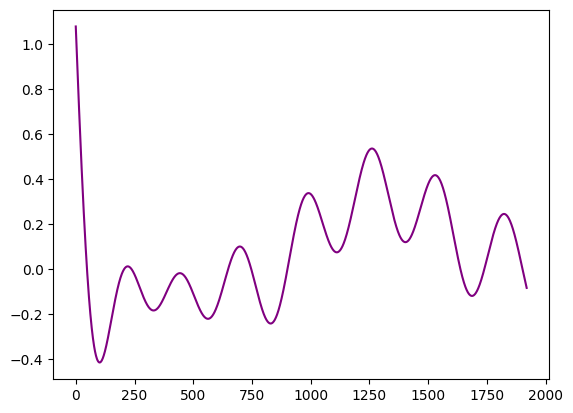

In [47]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(ba_list[:1920], color='purple' )#i
plt.show()

In [30]:
x.shape

torch.Size([1079, 7680])

In [26]:
x.shape

torch.Size([1079, 7680])

In [42]:
print(x.shape)
print(y[1])

torch.Size([1079, 7680])
tensor([  0,  30, 256])


In [183]:
stage=5
flag=False
start=0
cnt=0
for i,j in enumerate(y):
    if (flag==True) and (j[0]!=stage):
        end = i
        break
    if (flag==False) and (j[0]==stage):
        if cnt<1:
            cnt+=1
        else:
            start = i
            flag = True

In [161]:
y[end]

tensor([   0, 3600,  256])

In [171]:
y[end-1]

tensor([   3, 2160,  256])

In [163]:
int(end/2+start/2)

119

In [188]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(x[int(end/2+start/2),:])
peak_count = len(peaks)

print("信号波峰次数：", peak_count)

信号波峰次数： 70


In [185]:
print(start,end)

224 231


In [142]:
import torch
import numpy as np
np.unique(torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/test/y_'+str(file_id)+'.pt')[:,0])

array([0, 1, 2, 3, 4, 5])

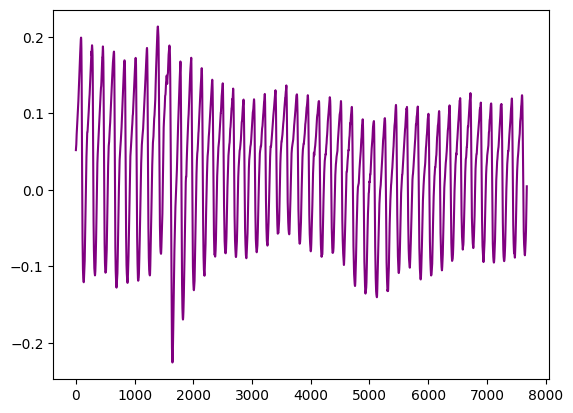

In [186]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(x[int(end/2+start/2),:], color='purple' )#i
plt.show()

In [111]:
np.unique(all_y[:,0])

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [102]:
all_x[0].shape

torch.Size([1920])

In [78]:
x_clean = torch.tensor([])
for i in x:
    f = interp1d(np.linspace(0,i.shape[0],i.shape[0]), i)
    new_x = torch.tensor(f(np.linspace(0, i.shape[0], 30*64)))
    new_x = new_x.resize( 1, new_x.shape[0])
    x_clean = torch.concat((x_clean,new_x),axis=0)

In [94]:
mean = torch.mean(x_clean)
std = torch.std(x_clean)
# 标准化变量
std_x = (x_clean - mean) / std

In [89]:
mean = torch.mean(x_clean[0,:])
std = torch.std(x_clean[0,:])
std_x = (x_clean[0,:] - mean) / std

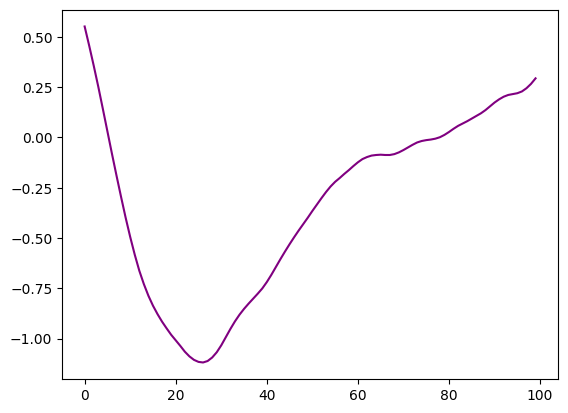

In [103]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(std_x[0,:100], color='purple' )
plt.show()

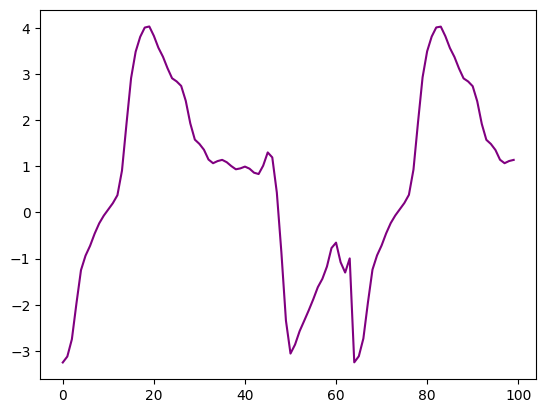

In [104]:
import matplotlib.pyplot as plt
ax = plt.axes()
ax.plot(all_x[0,:100], color='purple' )
plt.show()

In [55]:
from scipy.interpolate import interp1d
f = interp1d(np.linspace(0,temp.shape[0],temp.shape[0]), temp)
new_y = f(np.linspace(0, temp.shape[0], 30*64))
new_y.shape

(1920,)

In [25]:
torch.tensor([])

tensor([])

In [26]:
torch.concat((torch.tensor([]),temp),axis=0).shape
#temp = torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/'+spl+'/y_'+str(file_id)+'.pt')
#temp

torch.Size([1195, 3])

In [15]:
np.std(edf_file.readSignal(signal_labels.index('Pleth')))

0.1378149446790682

In [79]:
y = list()
x = list()
ppg = edf_file.readSignal(signal_labels.index('Pleth'))
for i in raw_labeled_sleep:
    freq = int(edf_file.getSampleFrequencies()[signal_labels.index('Pleth')])
    for start in range(int(i[1]),int(i[1]+i[2]),30):
        y.append([i[0],start,freq])
        x.append(ppg[start*freq:(30+start)*freq])
    torch.save(torch.tensor(x),'/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/test/test.pt')

In [93]:
torch.load('/extern2/zgz/wq/sleep/sleep_stage_ppg/clean_mesa/test/test.pt')[1198].shape

torch.Size([7680])

In [82]:
np.array(x).shape

(1199, 7680)

In [78]:
va.reshape(1199,256)

ValueError: cannot reshape array of size 1199 into shape (1199,256)

In [23]:
all_files = MetadataService.get_all_files()
all_subjects = []
for file in all_files:
    file_id = file[-8:-4]
    all_subjects.append(file_id)
len(all_subjects)

2055

In [ ]:
raw_labeled_sleep = MesaPSGService.load_raw(file_id)
import pyedflib as pyedflib
edf_file = pyedflib.EdfReader('/extern2/zgz/wq/sleep/sleep_classifiers' + '/data/mesa/polysomnography/edfs/mesa-sleep-' + file_id + '.edf')
signal_labels = edf_file.getSignalLabels()

In [14]:
type(raw_labeled_sleep[0])

list

In [7]:
interval = Interval(start_time=0, end_time=np.shape(raw_labeled_sleep)[0])

In [11]:
np.shape(raw_labeled_sleep)

(35970,)

In [9]:
for timestamp in range(interval.start_time, interval.end_time, Epoch.DURATION):
    print(timestamp)

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1320
1350
1380
1410
1440
1470
1500
1530
1560
1590
1620
1650
1680
1710
1740
1770
1800
1830
1860
1890
1920
1950
1980
2010
2040
2070
2100
2130
2160
2190
2220
2250
2280
2310
2340
2370
2400
2430
2460
2490
2520
2550
2580
2610
2640
2670
2700
2730
2760
2790
2820
2850
2880
2910
2940
2970
3000
3030
3060
3090
3120
3150
3180
3210
3240
3270
3300
3330
3360
3390
3420
3450
3480
3510
3540
3570
3600
3630
3660
3690
3720
3750
3780
3810
3840
3870
3900
3930
3960
3990
4020
4050
4080
4110
4140
4170
4200
4230
4260
4290
4320
4350
4380
4410
4440
4470
4500
4530
4560
4590
4620
4650
4680
4710
4740
4770
4800
4830
4860
4890
4920
4950
4980
5010
5040
5070
5100
5130
5160
5190
5220
5250
5280
5310
5340
5370
5400
5430
5460
5490
5520
5550
5580
5610
5640
5670
5700
5730
5760
5790
5820
5850
5880
5910
5940
5970
6000
6030
6060
6090
6120
6150
6180
6210

In [4]:
import pyedflib as pyedflib
edf_file = pyedflib.EdfReader('/extern2/zgz/wq/sleep/sleep_classifiers' + '/data/mesa/polysomnography/edfs/mesa-sleep-' + file_id + '.edf')
signal_labels = edf_file.getSignalLabels()

In [12]:
edf_file.readSignal(signal_labels.index('Pleth')).shape[0]/edf_file.getSampleFrequencies()[signal_labels.index('Pleth')]

35999.0

In [11]:
edf_file.getSampleFrequencies()[signal_labels.index('Pleth')]

256.0